In [5]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from shapely.validation import explain_validity
from shapely.validation import make_valid
import xarray as xr

warnings.filterwarnings('ignore')
import seaborn as sns


from joblib import Parallel, delayed
import multiprocessing

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# WRF-Chem Grid for 2020

In [22]:
path_wrf = '/data2/lthapa/regrid_emissions/wrf_grid_2020_notime.nc'
dat_wrf = xr.open_dataset(path_wrf)


#get the lat/lon of the grid, these are the edges/corners
lat_centers = dat_wrf['lat'].values[0,:] #233 x 397
lon_centers = dat_wrf['lon'].values[0,:] #233 x 397

lat_corners = dat_wrf['lat_b'].values[0,:] #233 x 397
lon_corners = dat_wrf['lon_b'].values[0,:] #233 x 397


build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'WRF_GRID')

559 724
560 725
<xarray.Dataset>
Dimensions:   (cols_cor: 725, cols_ctr: 724, rows_cor: 560, rows_ctr: 559)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 552 553 554 555 556 557 558
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 ... 717 718 719 720 721 722 723
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 553 554 555 556 557 558 559
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 ... 718 719 720 721 722 723 724
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float32 29.92 29.93 29.93 ... 50.01 50.0
    LON_CTR   (rows_ctr, cols_ctr) float32 -133.3 -133.2 ... -97.12 -97.06
    LAT_COR   (rows_cor, cols_cor) float32 29.9 29.9 29.91 ... 50.03 50.02 50.01
    LON_COR   (rows_cor, cols_cor) float32 -133.3 -133.3 ... -97.08 -97.03


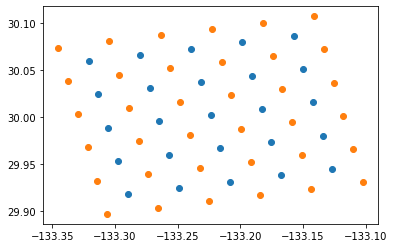

In [21]:
#proof that we have centers and corners
plt.scatter(dat_wrf['lon'].values[0,0:5, 0:5], dat_wrf['lat'].values[0,0:5, 0:5])
plt.scatter(dat_wrf['lon_b'].values[0,0:6, 0:6], dat_wrf['lat_b'].values[0,0:6, 0:6])

# West US Gridmet

In [14]:
path_gridmet = '/data2/lthapa/2019/GRIDMET/gridmet_all_2019-06-01.nc'
dat_gridmet = xr.open_dataset(path_gridmet)

#get the lat/lon of the grid
lat = dat_gridmet['lat'].values #432 elements, rows, y
lon = dat_gridmet['lon'].values #571 elements, columns, x


#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #430 elements
lon_sub = lon[1:len(lon)-1] #569 elements



#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 430x569

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 432x571
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 431x570
print(lon.shape, lon_corners.shape)


#build and save the grid
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'WESTUS_GRIDMET_GRID')

(432, 571) (431, 570)
430 569
431 570
<xarray.Dataset>
Dimensions:   (cols_cor: 570, cols_ctr: 569, rows_cor: 431, rows_ctr: 430)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 423 424 425 426 427 428 429
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 ... 562 563 564 565 566 567 568
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 424 425 426 427 428 429 430
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 ... 563 564 565 566 567 568 569
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 48.94 48.94 48.94 ... 31.07 31.07
    LON_CTR   (rows_ctr, cols_ctr) float64 -124.7 -124.7 ... -101.1 -101.1
    LAT_COR   (rows_cor, cols_cor) float64 48.96 48.96 48.96 ... 31.05 31.05
    LON_COR   (rows_cor, cols_cor) float64 -124.7 -124.7 ... -101.1 -101.0


# GRIDMET 

In [11]:
path_gridmet = '/data2/lthapa/2019/GRIDMET/bi_2019.nc'
dat_gridmet = xr.open_dataset(path_gridmet)

#get the lat/lon of the grid
lat = dat_gridmet['lat'].values #585 elements, rows, y
lon = dat_gridmet['lon'].values #1386 elements, columns, x

#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #583 elements
lon_sub = lon[1:len(lon)-1] #1384 elements

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 583x1384


#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 585x1386
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 584x1385
print(lon.shape, lon_corners.shape)


#build and save the grid
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'GRIDMET_GRID')

(585, 1386) (584, 1385)
583 1384
584 1385
<xarray.Dataset>
Dimensions:   (cols_cor: 1385, cols_ctr: 1384, rows_cor: 584, rows_ctr: 583)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 576 577 578 579 580 581 582
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 ... 1378 1379 1380 1381 1382 1383
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 577 578 579 580 581 582 583
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 ... 1379 1380 1381 1382 1383 1384
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 49.36 49.36 49.36 ... 25.11 25.11
    LON_CTR   (rows_ctr, cols_ctr) float64 -124.7 -124.7 -124.6 ... -67.14 -67.1
    LAT_COR   (rows_cor, cols_cor) float64 49.38 49.38 49.38 ... 25.09 25.09
    LON_COR   (rows_cor, cols_cor) float64 -124.7 -124.7 ... -67.12 -67.08


# 5km population density map

In [21]:
path_pop = '/data2/lthapa/static_maps/gpw_v4_population_density_rev11_2pt5_min.nc'
dat_pop = xr.open_dataset(path_pop)


#get the lat/lon of the grid
lat = dat_pop['latitude'].values #4320 elements, rows, y
lon = dat_pop['longitude'].values #8640 elements, columns, x


#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #4318 elements
lon_sub = lon[1:len(lon)-1] #8638 elements


#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 4318x8638


#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 4320x8640
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 4319x8639
print(lon.shape, lon_corners.shape)


#build and save the grid
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'POP_GRID')

(4320, 8640) (4319, 8639)
4318 8638
4319 8639
<xarray.Dataset>
Dimensions:   (cols_cor: 8639, cols_ctr: 8638, rows_cor: 4319, rows_ctr: 4318)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 ... 4312 4313 4314 4315 4316 4317
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 ... 8632 8633 8634 8635 8636 8637
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 ... 8633 8634 8635 8636 8637 8638
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 89.94 89.94 89.94 ... -89.94 -89.94
    LON_CTR   (rows_ctr, cols_ctr) float64 -179.9 -179.9 -179.9 ... 179.9 179.9
    LAT_COR   (rows_cor, cols_cor) float64 89.96 89.96 89.96 ... -89.96 -89.96
    LON_COR   (rows_cor, cols_cor) float64 -180.0 -179.9 -179.9 ... 179.9 180.0


## 3km RAVE Grid

In [17]:
path_rave = '/data2/lthapa/2020/RAVE/07/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_s202007010000000_e202007012359590_c202303131140500.nc'
dat_rave = xr.open_dataset(path_rave)

lat_centers = dat_rave['grid_latt'].values #center latitudes
lon_centers = dat_rave['grid_lont'].values-360 #center longitudes
lat_corners = dat_rave['grid_lat'].values #corner latitudes
lon_corners = dat_rave['grid_lon'].values-360 #corner longitudes

build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'RAVE_GRID_3KM')

1133 2500
1134 2501
<xarray.Dataset>
Dimensions:   (cols_cor: 2501, cols_ctr: 2500, rows_cor: 1134, rows_ctr: 1133)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 ... 1127 1128 1129 1130 1131 1132
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 ... 2494 2495 2496 2497 2498 2499
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 ... 1128 1129 1130 1131 1132 1133
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 ... 2495 2496 2497 2498 2499 2500
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float32 53.97 53.97 53.97 ... 20.01 20.01
    LON_CTR   (rows_ctr, cols_ctr) float32 -135.0 -135.0 ... -60.05 -60.02
    LAT_COR   (rows_cor, cols_cor) float32 53.99 53.99 53.99 ... 20.0 20.0 20.0
    LON_COR   (rows_cor, cols_cor) float32 -135.0 -135.0 -134.9 ... -60.03 -60.0


## NCAR Moisture Grid

In [11]:
path_ncar = '/data2/lthapa/2020/FMC/fmc_20200506_20Z.nc'
dat_ncar = xr.open_dataset(path_ncar)

lat = dat_ncar['XLAT_M'].values[0,:] #3179, 5399
lon = dat_ncar['XLONG_M'].values[0,:] #3179, 5399
print(lat.shape, lon.shape)

#drop the outer ring of lat/lons
lat_centers = lat[1:lat.shape[0]-1,1:lat.shape[1]-1] #3177, 5397
lon_centers = lon[1:lon.shape[0]-1,1:lon.shape[1]-1] #3177, 5397
print(lat_centers.shape, lon_centers.shape)

lat_corners,lon_corners = calculate_grid_cell_corners(lat, lon)#3178, 5398
print(lat_corners.shape, lon_corners.shape) 

#make the grid
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'NCAR_MOISTURE_GRID')

(3179, 5399) (3179, 5399)
(3177, 5397) (3177, 5397)
(3178, 5398) (3178, 5398)
3177 5397
3178 5398
<xarray.Dataset>
Dimensions:   (cols_cor: 5398, cols_ctr: 5397, rows_cor: 3178, rows_ctr: 3177)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 ... 3171 3172 3173 3174 3175 3176
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 ... 5391 5392 5393 5394 5395 5396
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 ... 3172 3173 3174 3175 3176 3177
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 ... 5392 5393 5394 5395 5396 5397
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float32 21.13 21.13 21.13 ... 47.85 47.85
    LON_CTR   (rows_ctr, cols_ctr) float32 -122.7 -122.7 -122.7 ... -60.9 -60.88
    LAT_COR   (rows_cor, cols_cor) float32 21.12 21.12 21.13 ... 47.85 47.85
    LON_COR   (rows_cor, cols_cor) float32 -122.7 -122.7 ... -60.89 -60.88


## SMOPS Grid

In [12]:
path_smops = '/data2/lthapa/2020/SMOPS/NPR_SMOPS_CMAP_D20200802.nc'
dat_smops = xr.open_dataset(path_smops)
#print(dat_smops)

#get the lat/lon of the grid
lat = np.flip(np.arange(-89.875, 90,0.25)) #720 elements, rows, y
lon = np.arange(-179.875, 180,0.25) #1440 elements elements, columns, x
#print(lat)
#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #718 elements
lon_sub = lon[1:len(lon)-1] #1438 elements


#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 718x1438

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 720x1440
print(lat)
print(lon)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 719x1439


#build and save the grid
#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'MERRA_GRID')
#build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'SMOPS_GRID')


[[ 89.875  89.875  89.875 ...  89.875  89.875  89.875]
 [ 89.625  89.625  89.625 ...  89.625  89.625  89.625]
 [ 89.375  89.375  89.375 ...  89.375  89.375  89.375]
 ...
 [-89.375 -89.375 -89.375 ... -89.375 -89.375 -89.375]
 [-89.625 -89.625 -89.625 ... -89.625 -89.625 -89.625]
 [-89.875 -89.875 -89.875 ... -89.875 -89.875 -89.875]]
[[-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 ...
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]
 [-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]]


### MERRA2 GRID

In [11]:
path_merra = '/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20200801.nc4'
dat_merra = xr.open_dataset(path_merra)

#get the lat/lon of the grid
lat = dat_merra['lat'].values #37 elements, rows, y
lon = dat_merra['lon'].values #39 elements, columns, x
print(lat)
print(lon)

#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #35 elements
lon_sub = lon[1:len(lon)-1] #37 elements

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 35x37

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 37x39 
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 36x38

#build and save the grid
#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'MERRA_GRID')
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'MERRA_GRID')

<xarray.Dataset>
Dimensions:               (Latitude: 720, Longitude: 1440)
Dimensions without coordinates: Latitude, Longitude
Data variables: (12/40)
    Blended_SM            (Latitude, Longitude) float32 ...
    NRT_SMOS_SM           (Latitude, Longitude) float32 ...
    SMOS_SM               (Latitude, Longitude) float32 ...
    ASCAT_A_SM            (Latitude, Longitude) float32 ...
    ASCAT_B_SM            (Latitude, Longitude) float32 ...
    AMSR2_SM              (Latitude, Longitude) float32 ...
    ...                    ...
    ASCAT_B_QA            (Latitude, Longitude) int16 ...
    AMSR2_QA              (Latitude, Longitude) int16 ...
    GMI_QA                (Latitude, Longitude) int16 ...
    NSMAP_QA              (Latitude, Longitude) int16 ...
    SMAP_QA               (Latitude, Longitude) int16 ...
    Blended_SM_SD_QA      (Latitude, Longitude) int16 ...
Attributes: (12/17)
    Satellite:                        ESA's SMOS, EUMETSAT's MetOp-A and MetO...
    Inst

"#get the lat/lon of the grid\nlat = dat_merra['lat'].values #37 elements, rows, y\nlon = dat_merra['lon'].values #39 elements, columns, x\nprint(lat)\nprint(lon)\n\n#drop the outer ring of lat/lons\nlat_sub = lat[1:len(lat)-1] #35 elements\nlon_sub = lon[1:len(lon)-1] #37 elements\n\n#calculate the grid centers\nlon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 35x37\n\n#calculate the grid corners\nlon, lat = np.meshgrid(lon,lat) #these are 37x39 \nlat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 36x38\n\n#build and save the grid\n#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'MERRA_GRID')\nbuild_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'MERRA_GRID')"

## RAVE

In [ ]:
os.system('ncrename -v Latitude,lat -v Longitude,lon /data2/lthapa/2020/Apr2020_to_Oct2020/Hourly_Emissions_FV3_13km_202004070000_202004072300.nc /data2/lthapa/2020/Apr2020_to_Oct2020/Hourly_Emissions_FV3_13km_202004070000_202004072300xr.nc')


In [ ]:
path_rave = '/data2/lthapa/2020/Apr2020_to_Oct2020/Hourly_Emissions_FV3_13km_202004070000_202004072300xr.nc'
dat_rave = xr.open_dataset(path_rave)
print(dat_rave)
#get the lat/lon of the grid, these are the edges/corners
lat_corners = dat_rave['lat'].values #233 x 397
lon_corners = dat_rave['lon'].values - 360 #233 x 397
print(dat_rave['Latitude'].values)
#calculate the centers
lat_centers, lon_centers = calculate_grid_cell_corners(lat_corners, lon_corners)

#build and save the grid
#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'RAVE_GRID')
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'RAVE_GRID')

## ESI

In [7]:
path_esi = '/data2/lthapa/2020/ESI/DFPPM_4WK_2020323.nc'
dat_esi = xr.open_dataset(path_esi)

#get the lat/lon of the grid
lat = dat_esi['lat'].values #360 elements, rows, y
lon = dat_esi['lon'].values #480 elements, columns, x


#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #358 elements
lon_sub = lon[1:len(lon)-1] #478 elements

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 358x478

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 360x480
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 359x479
print(lon_corners.shape)

#build and save the grid
#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'ESI_GRID')
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'ESI_GRID')

(499, 999)
498 998
499 999
<xarray.Dataset>
Dimensions:   (cols_cor: 999, cols_ctr: 998, rows_cor: 499, rows_ctr: 498)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 491 492 493 494 495 496 497
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 ... 991 992 993 994 995 996 997
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 25.08 25.08 25.08 ... 49.93 49.93
    LON_CTR   (rows_ctr, cols_ctr) float64 -124.9 -124.9 ... -75.12 -75.07
    LAT_COR   (rows_cor, cols_cor) float64 25.05 25.05 25.05 ... 49.95 49.95
    LON_COR   (rows_cor, cols_cor) float64 -124.9 -124.9 -124.8 ... -75.1 -75.05


## PWS Grid

In [ ]:
path_pws = '/data2/lthapa/PWS_6_jan_2021.nc'
dat_pws = xr.open_dataset(path_pws)

#get the lat/lon of the grid
lat = dat_pws['lat'].values #645 elements, rows, y
lon = dat_pws['lon'].values #870 elements, columns, x

#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #643 elements
lon_sub = lon[1:len(lon)-1] #868 elements


#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 643x868

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 645x870
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 644x869

#build and save the grid
#build_grid_gdf(lat_corners, lon_corners, lat_centers, lon_centers, 'PWS_GRID')
build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'PWS_GRID')


## HRRR Grid

In [ ]:
path_hrrr = '/data2/lthapa/ML_daily/pygraf/Processed_HRRR_2020091800.nc'
dat_hrrr = xr.open_dataset(path_hrrr)

lat_centers = dat_hrrr['grid_latt'].values #1057x1797
lon_centers = dat_hrrr['grid_lont'].values #1057x1797

#drop the outer ring of lat/lons
lat_centers = lat_centers[1:lat_centers.shape[0],1:lat_centers.shape[1]] #1056x1796
lon_centers = lon_centers[1:lon_centers.shape[0],1:lon_centers.shape[1]] #1056x1796

#load in the corners
lat_corners = dat_hrrr['grid_lat'].values #1057x1797
lon_corners = dat_hrrr['grid_lon'].values #1057x1797

#build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'HRRR_GRID')


nrows = lat_centers.shape[0]
ncols = lat_centers.shape[1]

print(nrows, ncols)

row_ind = range(nrows)
col_ind =range(ncols)

print(multiprocessing.cpu_count())

tic = time.time()
results = Parallel(n_jobs=6)(delayed(build_one_gridcell)(lat_corners, lon_corners, lat_centers, lon_centers,i,j) for i in row_ind for j in col_ind)
toc = time.time()
print(toc-tic)

df_grid=gpd.GeoDataFrame(results)
df_grid.columns = ['lat', 'lon', 'row', 'col', 'geometry']
df_grid.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry

print(df_grid)
#tic =time.time()
#df_grid.to_file('HRRR_GRID.geojson', driver='GeoJSON')
#toc=time.time()
print(toc-tic)
#df_size = len(row_ind)*len(col_ind)
#df_grid = gpd.GeoDataFrame({'lat': np.zeros(df_size), 
#                                'lon': np.zeros(df_size),
#                                'row':np.zeros(df_size),
#                                'col':np.zeros(df_size),
#                                'geometry':np.zeros(df_size)})
#df_grid = Parallel(n_jobs=2)(delayed(store_grid)(df_grid,results,kk) for kk in range(df_size))
#print(df_grid)
#build_one_gridcell(lat_corners, lon_corners, lat_centers, lon_centers,0,0)


In [ ]:
def store_grid(grid,res, k):
    grid.iloc[k,:] = res[k]
    return grid

In [ ]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_one_gridcell(LAT_COR, LON_COR, LAT_CTR, LON_CTR, ii,jj):
    #print(ii,jj,count)
    #print(LAT_CTR[ii,jj], LON_CTR[ii,jj]) #ctr
    sw = (LON_COR[ii, jj],LAT_COR[ii, jj]) #SW
    se =(LON_COR[ii, jj+1],LAT_COR[ii, jj+1]) #SE
    nw = (LON_COR[ii+1, jj],LAT_COR[ii+1, jj]) #NW
    ne = (LON_COR[ii+1, jj+1],LAT_COR[ii+1, jj+1]) #NE
            
    poly_cell = Polygon([sw,nw,ne,se])
    
    return LAT_CTR[ii,jj], LON_CTR[ii,jj],ii,jj,poly_cell

## CPC FWI Grid

In [ ]:
path_cpc = '../FWI.CPC.Daily.WESTUS.20200801.nc'
dat_cpc = xr.open_dataset(path_cpc)

#get the lat/lon of the grid
lat = dat_cpc['lat'].values #36 elements, rows, y
lon = dat_cpc['lon'].values #48 elements, columns, x

#drop the outer ring of lat/lons
lat_sub = lat[1:len(lat)-1] #34 elements
lon_sub = lon[1:len(lon)-1] #46 elements

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 34x46

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 36x48
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 35x47

nrows = lat_centers.shape[0]
ncols = lat_centers.shape[1]

print(nrows, ncols)

row_ind = range(nrows)
col_ind =range(ncols)

print(multiprocessing.cpu_count())

tic = time.time()
results = Parallel(n_jobs=6)(delayed(build_one_gridcell)(lat_corners, lon_corners, lat_centers, lon_centers,i,j) for i in row_ind for j in col_ind)
toc = time.time()
print(toc-tic)

df_grid=gpd.GeoDataFrame(results)
df_grid.columns = ['lat', 'lon', 'row', 'col', 'geometry']
df_grid.set_geometry(col='geometry', inplace=True) #assign a column to represent geometry

print(df_grid)
tic =time.time()
df_grid.to_file('CPC_FWI_GRID.geojson', driver='GeoJSON')
toc=time.time()
print(toc-tic)

## IMERG FWI Grid

In [26]:
path_imerg = '../2020/FWI_IMERG/WESTUS_FWI.IMERG.FINAL.v6.Daily.Default.20200701.nc'
dat_imerg = xr.open_dataset(path_imerg)

#get the lat/lon of the grid
lat = dat_imerg['lat'].values #1330 elements, rows, y
print(lat)
lon = dat_imerg['lon'].values #3600 elements, columns, x

#drop the outer ring of lat/lons, these will be the centers we save
lat_sub = lat[1:len(lat)-1] #1328 elements
lon_sub = lon[1:len(lon)-1] #3598 elements

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 1328X3598

#calculate the grid corners
lon, lat = np.meshgrid(lon,lat) #these are 1330x3600
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 1329x3599


build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'IMERG_FWI_GRID')


[25.04999924 25.14999771 25.25000381 25.35000229 25.45000076 25.54999924
 25.64999771 25.75000381 25.85000229 25.95000076 26.04999924 26.14999771
 26.25000381 26.35000229 26.45000076 26.54999924 26.64999771 26.75000381
 26.85000229 26.95000076 27.04999924 27.14999771 27.25000381 27.35000229
 27.45000076 27.54999924 27.64999771 27.75000381 27.85000229 27.95000076
 28.04999924 28.14999771 28.25000381 28.35000229 28.45000076 28.54999924
 28.64999771 28.75000381 28.85000229 28.95000076 29.04999924 29.14999771
 29.25000381 29.35000229 29.45000076 29.54999924 29.64999771 29.75000381
 29.85000229 29.95000076 30.04999924 30.14999771 30.25000381 30.35000229
 30.45000076 30.54999924 30.64999771 30.75000381 30.85000229 30.95000076
 31.04999924 31.14999771 31.25000381 31.35000229 31.45000076 31.54999924
 31.64999771 31.75000381 31.85000229 31.95000076 32.04999924 32.14999771
 32.25000381 32.35000229 32.45000076 32.54999924 32.64999771 32.75000381
 32.85000229 32.95000076 33.04999924 33.14999771 33

## Fuel Loading Grid (1KM)

In [ ]:
path_fuel_loading = '/data/lthapa/GSL_Internship/fuel_loading_FCCS16.nc'
dat_fuel_loading = xr.open_dataset(path_fuel_loading)


lat = dat_fuel_loading['grid_latt'].values #3215x5551
lon = dat_fuel_loading['grid_lont'].values #3215x5551
print(lat.shape,lon.shape)

#drop the outer ring of lat/lons
lat_centers = lat[1:lat.shape[0]-1,1:lat.shape[1]-1] #3213x5549
lon_centers = lon[1:lon.shape[0]-1,1:lon.shape[1]-1] #3213x5549
print(lat_centers.shape,lon_centers.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 3214x5550
print(lat_corners.shape, lon_corners.shape)

build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'FUEL_LOADING_GRID')

## Fuel Loading by FWI Grid

In [ ]:
path_fuel_loading = '/data2/lthapa/FCCS_Fuel_Fire_Danger_Metric_LonLat.nc'
dat_fuel_loading = xr.open_dataset(path_fuel_loading) #in albers_conical_equal_area projection
#print(dat_fuel_loading)

lat = dat_fuel_loading['lat'].values #88713
lon = dat_fuel_loading['lon'].values #192676
print(lat.shape,lon.shape)


#drop the outer ring of lat/lons
lat_sub = lat[1:lat.shape[0]-1] #88711
lon_sub = lon[1:lon.shape[0]-1] #192674
print(lat_sub.shape,lon_sub.shape)

#calculate the grid centers
lon_centers, lat_centers = np.meshgrid(lon_sub, lat_sub) #these are 35x37
print(lon_centers.shape)

#lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon) #these are 3214x5550
#print(lat_corners.shape, lon_corners.shape)

#build_grid_netcdf(lat_corners, lon_corners, lat_centers, lon_centers, 'FUEL_LOADING_GRID')

In [ ]:
from PIL import Image 
Image.MAX_IMAGE_PIXELS = 16000000000 

In [ ]:
im = Image.open('/data2/lthapa/FCCS_Fuel_Fire_Danger_Metric.tif')
imarray = np.array(im)

## Helper Function

In [1]:
#LAT and LON are 2d arrays
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [2]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_one_gridcell(LAT_COR, LON_COR, LAT_CTR, LON_CTR, ii,jj):
    #print(ii,jj,count)
    #print(LAT_CTR[ii,jj], LON_CTR[ii,jj]) #ctr
    sw = (LON_COR[ii, jj],LAT_COR[ii, jj]) #SW
    se =(LON_COR[ii, jj+1],LAT_COR[ii, jj+1]) #SE
    nw = (LON_COR[ii+1, jj],LAT_COR[ii+1, jj]) #NW
    ne = (LON_COR[ii+1, jj+1],LAT_COR[ii+1, jj+1]) #NE
            
    poly_cell = Polygon([sw,nw,ne,se])
    
    return LAT_CTR[ii,jj], LON_CTR[ii,jj],ii,jj,poly_cell

In [3]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_grid_gdf(LAT_COR, LON_COR, LAT_CTR, LON_CTR, filename):
    #loop over the centers
    nrows = LAT_CTR.shape[0]
    ncols = LAT_CTR.shape[1]
    print(nrows, ncols)

    #preallocate the dataframe
    df_size = nrows*ncols
    df_grid = gpd.GeoDataFrame({'lat': np.zeros(df_size), 
                                'lon': np.zeros(df_size),
                                'row':np.zeros(df_size),
                                'col':np.zeros(df_size),
                                'geometry':np.zeros(df_size)})

    count=0
    for ii in range(nrows):
        for jj in range(ncols):
            #print(ii,jj,count)
            #print(LAT_CTR[ii,jj], LON_CTR[ii,jj]) #ctr
            sw = (LON_COR[ii, jj],LAT_COR[ii, jj]) #SW
            se =(LON_COR[ii, jj+1],LAT_COR[ii, jj+1]) #SE
            nw = (LON_COR[ii+1, jj],LAT_COR[ii+1, jj]) #NW
            ne = (LON_COR[ii+1, jj+1],LAT_COR[ii+1, jj+1]) #NE
            
            poly_cell = Polygon([sw,nw,ne,se])
            df_grid.iloc[count,:] = [LAT_CTR[ii,jj], LON_CTR[ii,jj],ii,jj,poly_cell]

            
            count=count+1
    print(df_grid)
    df_grid.set_geometry(col='geometry', inplace=True)
    df_grid.to_file(filename+'.geojson', driver='GeoJSON')

In [4]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_grid_netcdf(LAT_COR, LON_COR, LAT_CTR, LON_CTR, filename):
    #loop over the centers
    nrows_center = LAT_CTR.shape[0]
    ncols_center = LAT_CTR.shape[1]
    print(nrows_center, ncols_center)

    nrows_corner = LAT_COR.shape[0]
    ncols_corner = LAT_COR.shape[1]
    print(nrows_corner,ncols_corner)
    
    rows_ctr = np.arange(nrows_center)
    cols_ctr = np.arange(ncols_center)
    rows_cor = np.arange(nrows_corner)
    cols_cor = np.arange(ncols_corner)

    
    dat_grid = xr.Dataset(
        data_vars = dict(
            LAT_CTR=(['rows_ctr','cols_ctr'],LAT_CTR),
            LON_CTR=(['rows_ctr','cols_ctr'],LON_CTR),
            LAT_COR=(['rows_cor','cols_cor'],LAT_COR),
            LON_COR=(['rows_cor','cols_cor'],LON_COR),
        ),
        
        coords = dict(
            rows_ctr =(['rows_ctr'],rows_ctr),
            cols_ctr =(['cols_ctr'],cols_ctr),
            rows_cor =(['rows_cor'],rows_cor),
            cols_cor =(['cols_cor'],cols_cor),
        
        )
        
    )
    print(dat_grid)
    dat_grid.to_netcdf(filename+'.nc')